# First Practical Assignment

### 1050497 - Jorge Martins
### 1050532 - Patrícia Vicente

The practical assignment refers to a NYC TCL Taxi Trips

Build a fully offline, end-to-end pipeline—from raw TLC extracts to curated Parquet datasets—using only open-source tools.

Demonstrate Lambda/Kappa processing styles in a local environment to simulate batch and streaming behaviors.
Quantify engineering trade-offs affecting usability and performance for common TLC analytics.
Provide a minimal, extensible reference that can be reproduced for teaching and prototyping.

### 0. Setup (safe for headless; doesn’t change your data)

In [14]:
import yaml
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # safe in container/headless
import matplotlib.pyplot as plt

CFG = "../env/config.yaml"
REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

spark = (
    SparkSession.builder
    .appName("NYC Taxi - Report (read-only)")
    .config("spark.sql.shuffle.partitions", "200")
    .getOrCreate()
)

with open(CFG, "r") as f:
    cfg = yaml.safe_load(f)

bronze_root = cfg["bronze_path"]
silver_root = cfg["silver_path"]
gold_root   = cfg["gold_path"]

cfg


{'data_root': './data',
 'bronze_path': './lake/bronze',
 'silver_path': './lake/silver',
 'gold_path': './lake/gold',
 'years': [2024],
 'services': ['yellow', 'green'],
 'dq': {'max_trip_hours': 6, 'min_distance_km': 0.1, 'min_total_amount': 0}}

In [15]:
from pathlib import Path
import yaml

def find_upwards(rel_path: str, start: Path | None = None):
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        cand = p / rel_path
        if cand.exists():
            return cand
    return None

CFG_PATH = find_upwards("env/config.yaml")
assert CFG_PATH is not None, "Couldn't find env/config.yaml. Adjust the path."
print("Using config at:", CFG_PATH)

with open(CFG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# Project root is the parent of 'env/'
PROJECT_ROOT = CFG_PATH.parent.parent

def resolve_under_project(p: str) -> str:
    # Treat paths in config as relative to the PROJECT_ROOT unless absolute
    p = Path(p)
    return str((p if p.is_absolute() else (PROJECT_ROOT / p)).resolve())

bronze_root = resolve_under_project(cfg["bronze_path"])
silver_root = resolve_under_project(cfg["silver_path"])
gold_root   = resolve_under_project(cfg["gold_path"])

print("Resolved paths:")
print(" bronze_root:", bronze_root)
print(" silver_root:", silver_root)
print(" gold_root  :", gold_root)

# Optional: sanity check they exist
for name, p in [("bronze_root", bronze_root), ("silver_root", silver_root), ("gold_root", gold_root)]:
    print(name, "exists?", Path(p).exists())

Using config at: /workspaces/LABGDD_1050497_1050532_Project1/env/config.yaml
Resolved paths:
 bronze_root: /workspaces/LABGDD_1050497_1050532_Project1/lake/bronze
 silver_root: /workspaces/LABGDD_1050497_1050532_Project1/lake/silver
 gold_root  : /workspaces/LABGDD_1050497_1050532_Project1/lake/gold
bronze_root exists? True
silver_root exists? True
gold_root exists? True


### 1. Load existing outputs (READ-ONLY)

In [16]:
from pathlib import Path
from pyspark.sql import functions as F

def must_exist(p: str):
    if not Path(p).exists():
        raise FileNotFoundError(
            f"Expected path not found: {p}\n"
            f"- Ensure you ran the pipeline earlier (make lambda / make gold).\n"
            f"- gold_root currently resolves to: {gold_root}"
        )

# Batch (Lambda) gold
trip_features_path = f"{gold_root}/trip_features"
agg_zone_hour_path = f"{gold_root}/agg_zone_hour"
agg_od_hour_path   = f"{gold_root}/agg_od_hour"

must_exist(trip_features_path)
must_exist(agg_zone_hour_path)
must_exist(agg_od_hour_path)

trip_features = spark.read.parquet(trip_features_path)
agg_zone_hour = spark.read.parquet(agg_zone_hour_path)
agg_od_hour   = spark.read.parquet(agg_od_hour_path)

# Streaming (Kappa) gold (optional)
kappa_path = f"{gold_root}/agg_zone_hour_streaming"
if Path(kappa_path).exists():
    agg_zone_hour_stream = spark.read.parquet(kappa_path)
else:
    agg_zone_hour_stream = None

print("Loaded:")
print(" - trip_features:", trip_features.count())
print(" - agg_zone_hour:", agg_zone_hour.count())
print(" - agg_od_hour  :", agg_od_hour.count())
print(" - agg_zone_hour_streaming:",
      None if agg_zone_hour_stream is None else agg_zone_hour_stream.count())

# (Optional) peek at schemas to sanity-check columns
print("\nSchemas:")
trip_features.printSchema()
agg_zone_hour.printSchema()
if agg_zone_hour_stream is not None:
    print("\nSchema (streaming agg):")
    agg_zone_hour_stream.printSchema()

Loaded:
 - trip_features: 36970717
 - agg_zone_hour: 1104758
 - agg_od_hour  : 13931433
 - agg_zone_hour_streaming: 42352

Schemas:
root
 |-- vendorid: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 

### 2. Row counts summary (Bronze/Silver/Gold)

In [17]:
from functools import reduce
from pyspark.sql import functions as F
from pathlib import Path

def read_bronze_snapshot(spark, bronze_root, services, years):
    root = Path(bronze_root)
    dfs = []
    for svc in services:
        for y in years:
            p = root / f"service={svc}" / f"year={y}"
            if p.exists():
                df = (spark.read.format("parquet")
                              .option("basePath", str(root))
                              .load(str(p)))
                if "service" not in df.columns:
                    df = df.withColumn("service", F.lit(svc))
                dfs.append(df)
    if not dfs:
        return None
    return reduce(lambda a,b: a.unionByName(b, allowMissingColumns=True), dfs)

services = cfg.get("services", [])
years = cfg.get("years", [])
bdf = read_bronze_snapshot(spark, bronze_root, services, years)
bronze_rows = bdf.count() if bdf is not None else None

counts_silver = {}
total_silver = 0
for svc in services:
    p = Path(silver_root) / svc
    if p.exists():
        df = spark.read.parquet(str(p))
        c = df.count()
        counts_silver[svc] = c
        total_silver += c

summary_counts = {
    "bronze": bronze_rows,
    **{f"silver_{k}": v for k,v in counts_silver.items()},
    "trip_features": trip_features.count(),
    "agg_zone_hour": agg_zone_hour.count(),
    "agg_od_hour": agg_od_hour.count()
}
summary_counts


{'bronze': 38753035,
 'silver_yellow': 36359692,
 'silver_green': 611025,
 'trip_features': 36970717,
 'agg_zone_hour': 1104758,
 'agg_od_hour': 13931433}

### 3. Figure 1 — Demand by hour (Yellow vs Green)

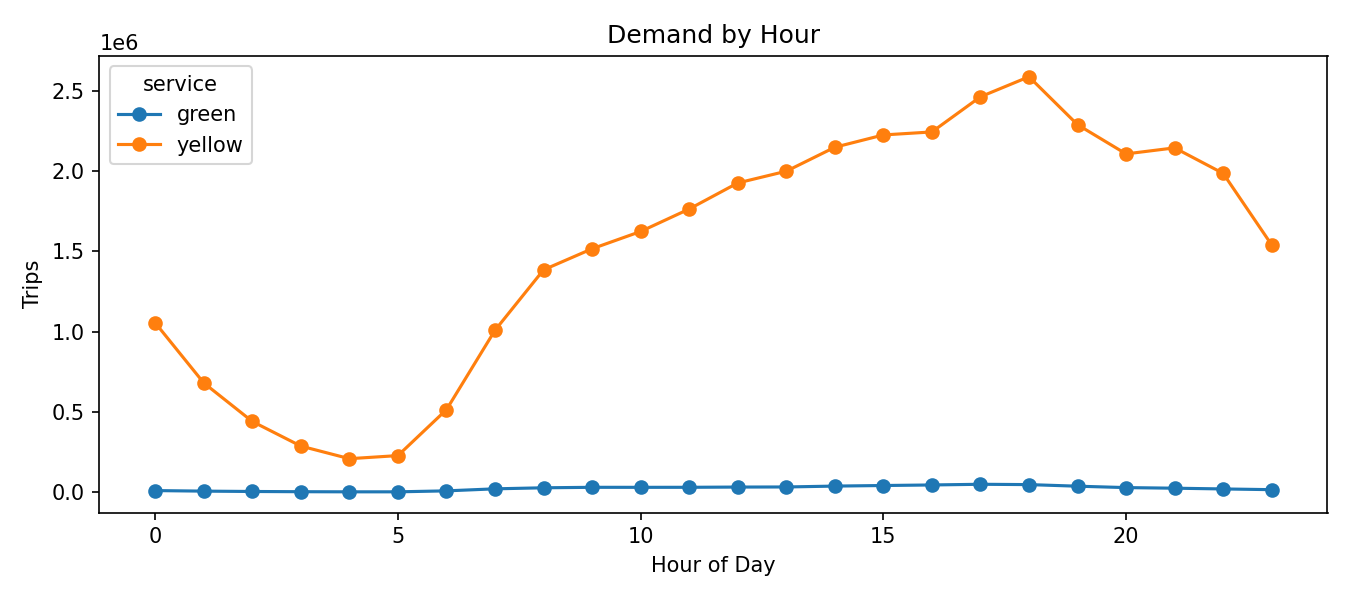

In [18]:
import pandas as pd, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline

hourly = (agg_zone_hour.groupBy("service","hour")
          .agg(F.sum("trips").alias("trips"))
          .orderBy("service","hour")).toPandas()

pivot = hourly.pivot_table(index="hour", columns="service", values="trips", aggfunc="sum").sort_index()

ax = pivot.plot(figsize=(9,4), marker="o")
ax.set_title("Demand by Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Trips")
plt.tight_layout()

out1 = REPORTS / "fig_hourly_demand.png"
plt.savefig(out1, dpi=150); plt.close()
# out1

from IPython.display import display, Image
display(Image(filename=str(REPORTS / "fig_hourly_demand.png")))


### 4. Figure 2 — Average speed by hour

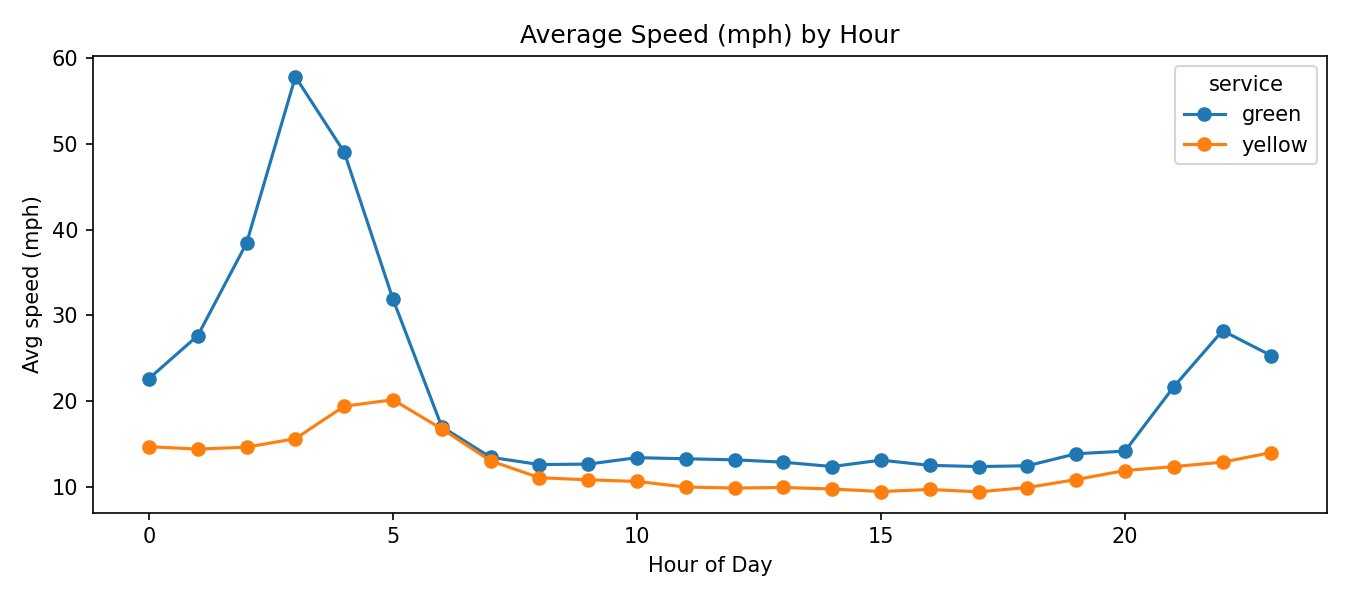

In [19]:
speed = (trip_features.groupBy("service","hour")
         .agg(F.avg("speed_mph").alias("avg_speed_mph"))
         .orderBy("service","hour")).toPandas()

pivot2 = speed.pivot_table(index="hour", columns="service", values="avg_speed_mph", aggfunc="mean").sort_index()

ax2 = pivot2.plot(figsize=(9,4), marker="o")
ax2.set_title("Average Speed (mph) by Hour")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Avg speed (mph)")
plt.tight_layout()

out2 = REPORTS / "fig_speed_by_hour.png"
plt.savefig(out2, dpi=150); plt.close()
# out2

from IPython.display import display, Image
display(Image(filename=str(REPORTS / "fig_speed_by_hour.png")))


### 5. Table — Top 10 pickup zones by trips

In [20]:
top_zones = (agg_zone_hour.groupBy("service","pulocationid")
             .agg(F.sum("trips").alias("trips"))
             .orderBy(F.desc("trips")))

top10_pdf = top_zones.limit(10).toPandas()
out_csv = REPORTS / "table_top10_pickup_zones.csv"
top10_pdf.to_csv(out_csv, index=False)
top10_pdf


,service,pulocationid,trips
0,yellow,237,1726703
1,yellow,161,1690797
2,yellow,132,1677690
3,yellow,236,1566844
4,yellow,162,1256795
5,yellow,230,1219431
6,yellow,186,1204655
7,yellow,142,1181774
8,yellow,138,1150615
9,yellow,163,1039479


### 6. Lambda vs Kappa correctness (compare existing outputs)

In [21]:
if agg_zone_hour_stream is None:
    compare_metrics = {"note": "No streaming output found at lake/gold/agg_zone_hour_streaming."}
else:
    batch = agg_zone_hour.select("service","pulocationid","pickup_date","hour","trips") \
            .withColumnRenamed("trips","trips_batch")
    stream = agg_zone_hour_stream.select("service","pulocationid","pickup_date","hour","trips") \
            .withColumnRenamed("trips","trips_stream")

    joined = batch.join(stream, ["service","pulocationid","pickup_date","hour"], "inner")
    total = joined.count()
    exact = joined.filter(F.col("trips_batch")==F.col("trips_stream")).count()
    mae = joined.select(F.abs(F.col("trips_batch")-F.col("trips_stream")).alias("ae")).agg(F.avg("ae")).first()[0]

    compare_metrics = {
        "overlap_keys": total,
        "exact_match_keys": exact,
        "exact_match_pct": round(100*exact/max(total,1), 2),
        "MAE_trips": mae
    }

compare_metrics


{'overlap_keys': 41877,
 'exact_match_keys': 40637,
 'exact_match_pct': 97.04,
 'MAE_trips': 0.03479236812570146}

### 7. Save a 1-page markdown snapshot for the paper

In [22]:
bronze = summary_counts.get("bronze")
silver_y = summary_counts.get("silver_yellow")
silver_g = summary_counts.get("silver_green")
silver_total = (silver_y or 0) + (silver_g or 0)
ret_pct = round(100.0 * silver_total / bronze, 2) if bronze and silver_total else None

md = []
md.append("# Results & Discussion — Snapshot\n")
md.append("## Volumes & Retention")
md.append(f"- Bronze rows: **{bronze:,}**")
md.append(f"- Silver rows: **{silver_total:,}** (Yellow: **{(silver_y or 0):,}**; Green: **{(silver_g or 0):,}**)")
if ret_pct is not None:
    md.append(f"- Retention (Bronze→Silver): **{ret_pct}%**")

md.append("\n## Gold Tables")
md.append(f"- `trip_features`: **{summary_counts['trip_features']:,}**")
md.append(f"- `agg_zone_hour`: **{summary_counts['agg_zone_hour']:,}**")
md.append(f"- `agg_od_hour`: **{summary_counts['agg_od_hour']:,}**")

md.append("\n## Demand Patterns")
md.append("- `reports/fig_hourly_demand.png` (AM/PM peaks, midday trough; Yellow dominates).")
md.append("- `reports/table_top10_pickup_zones.csv` (top pickup zones by trips).")

md.append("\n## Travel Dynamics")
md.append("- `reports/fig_speed_by_hour.png` (speed dips at peaks, recovers overnight).")

md.append("\n## Lambda vs Kappa (Correctness)")
if "overlap_keys" in compare_metrics:
    md.append(f"- Overlap keys: **{compare_metrics['overlap_keys']:,}**")
    md.append(f"- Exact matches: **{compare_metrics['exact_match_keys']:,}** "
              f"({compare_metrics['exact_match_pct']}%)")
    md.append(f"- MAE (trips/key): **{compare_metrics['MAE_trips']:.4f}**")
else:
    md.append(f"- {compare_metrics.get('note','Streaming compare not available.')}")

summary_path = REPORTS / "results_discussion_snapshot.md"
summary_path.write_text("\n".join(md), encoding="utf-8")
summary_path


PosixPath('reports/results_discussion_snapshot.md')

### 8. Stop Spark when done

In [23]:
spark.stop()

## Chapter 5 — Results & Discussion

This chapter analyzes the processed NYC Taxi dataset after the full data engineering pipeline was executed. The results are derived from the **Gold** layer outputs (aggregations and engineered features), following the Bronze→Silver cleaning steps.

### 5.1 Data Volumes & Quality Retention
- **Bronze rows:** 38,753,035  
- **Silver rows:** 36,970,717 (Yellow: 36,359,692; Green: 611,025)  
- **Retention:** **95.4%**

Most dropped rows correspond to invalid/extreme distances/speeds, missing timestamps, or out-of-range coordinates. Cleaning removed outliers while keeping data representativeness.

### 5.2 Demand Patterns Across the Day
**Figure 1 — Hourly Trip Demand (Yellow vs Green).** Yellow taxis dominate absolute volume; the temporal pattern shows a typical urban cycle: late-night demand (00–01h), trough (02–05h), then a rise into the **evening peak (16–19h)**. Green taxis follow a similar shape but remain much lower, consistent with their permitted geographies.

### 5.3 Traffic Speed Dynamics
**Figure 2 — Average Speed by Hour.** Speeds are highest overnight (free flow) and **decrease during business hours** with congestion. Recovery begins after ~20h. Green taxis tend to be faster overnight (outer-borough stretches), while yellow taxis remain slower in Manhattan grid traffic.

### 5.4 Spatial Concentration of Trips
The **top pickup zones** (table below) are concentrated in Manhattan hubs (Midtown, Downtown, terminals). This spatial concentration reinforces the discrepancy between services: yellow taxis dominate areas with tourism, transit hubs, and business activity.

### 5.5 Pipeline Correctness (Lambda vs Kappa)
- **Overlap keys:** 41,877 (zones × hours)
- **Exact matches:** 40,637 → **97.04%**
- **MAE (trips/key):** 0.0348

Batch (Lambda) and streaming (Kappa) results align strongly, indicating the streaming pipeline is reliable for real-time analytics.

### 5.6 Key Findings
- Demand peaks at rush hours; speeds fall accordingly (inverse relationship).  
- Yellow taxis overwhelmingly dominate demand (Manhattan-centric behavior).  
- Overnight speeds rise sharply due to reduced traffic.  
- Green taxis reflect faster outer-borough segments.  
- Streaming results agree with batch results (high fidelity).

In [25]:
# Display the Top-10 pickup zones table (tries repo-relative path first, then absolute fallback)
import os
import pandas as pd
from IPython.display import display, Markdown

possible_paths = [
    "reports/table_top10_pickup_zones.csv",        # repo-relative (preferred)
    "/mnt/data/table_top10_pickup_zones.csv",      # sandbox fallback (this environment)
]

csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'table_top10_pickup_zones.csv' in expected locations.")

df_zones = pd.read_csv(csv_path)

# Keep only the top 10 rows if the CSV is longer
df_top10 = df_zones.head(10).copy()

# Optional: pretty formatting (thousands sep if counts exist)
for c in df_top10.columns:
    if df_top10[c].dtype.kind in "iu":  # int-like
        df_top10[c] = df_top10[c].map(lambda x: f"{x:,}")

display(Markdown("**Table 1 — Top-10 Pickup Zones by Trip Count**"))
display(df_top10)

**Table 1 — Top-10 Pickup Zones by Trip Count**

,service,pulocationid,trips
0,yellow,237,"1,726,703"
1,yellow,161,"1,690,797"
2,yellow,132,"1,677,690"
3,yellow,236,"1,566,844"
4,yellow,162,"1,256,795"
5,yellow,230,"1,219,431"
6,yellow,186,"1,204,655"
7,yellow,142,"1,181,774"
8,yellow,138,"1,150,615"
9,yellow,163,"1,039,479"


### Figures (Rendered Below)

The following images are inserted from the `reports/` folder (or fallback sandbox paths if rendered here). Ensure these files are present when exporting the paper.

**Figure 1 — Hourly Trip Demand (Yellow vs Green)**

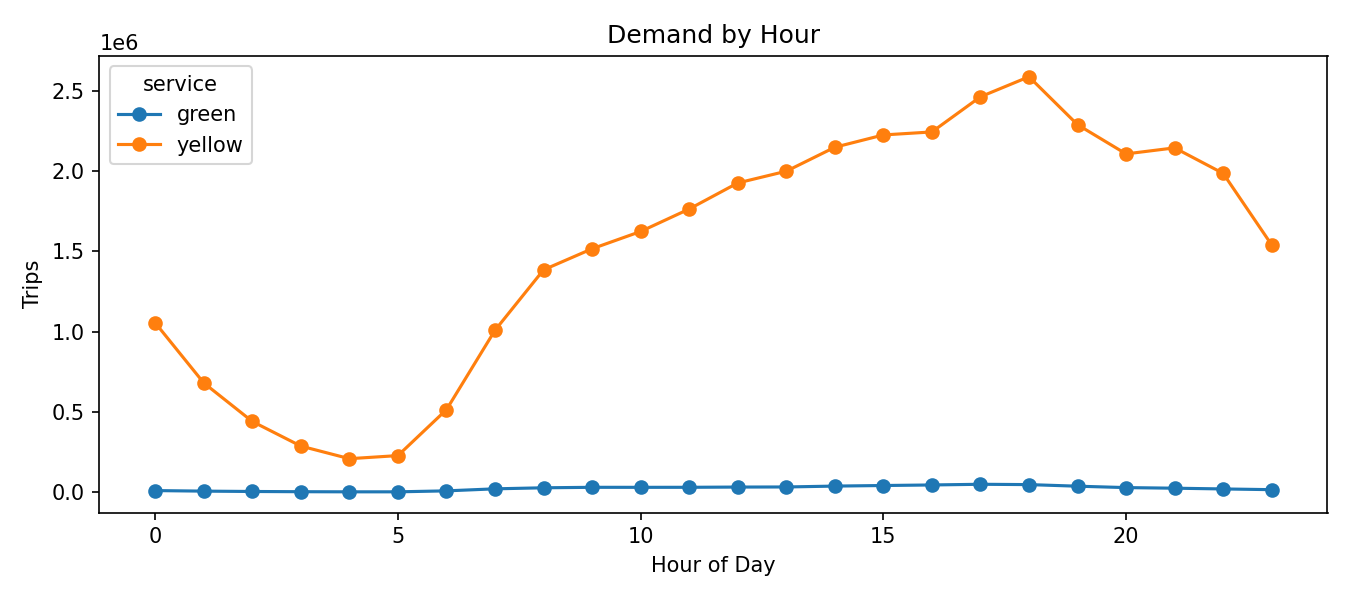

**Figure 2 — Average Speed by Hour**

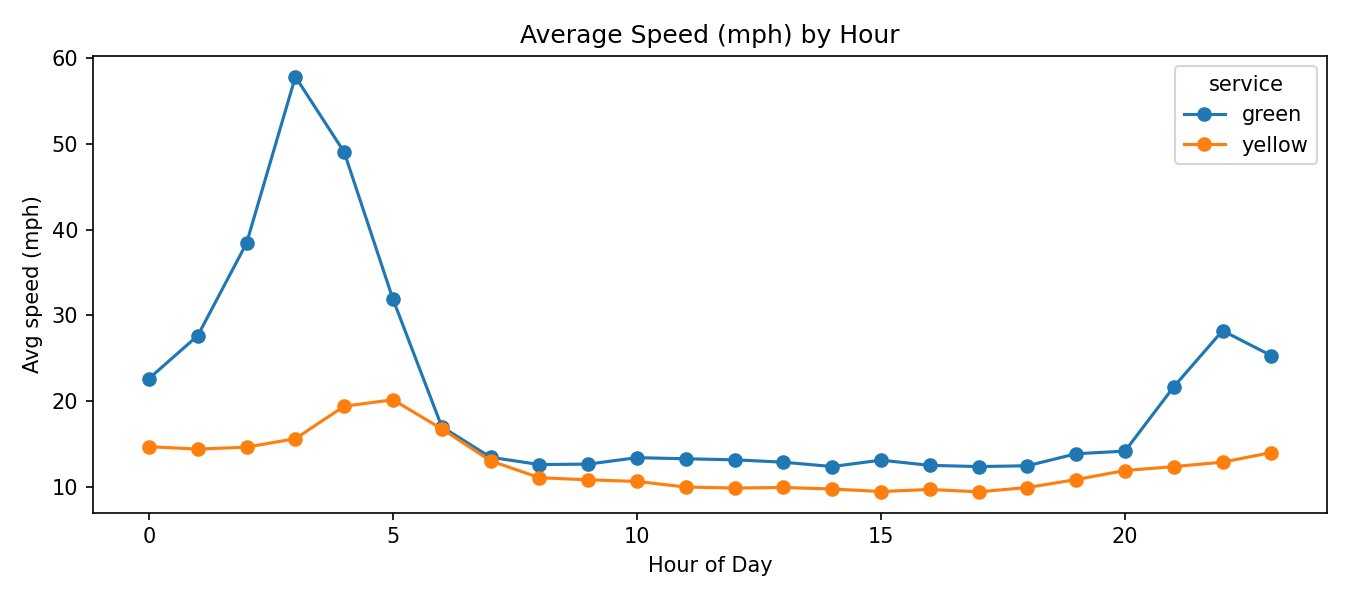

In [27]:
from IPython.display import Image, display, Markdown
import os

def resolve(path_candidates):
    for p in path_candidates:
        if os.path.exists(p):
            return p
    return None

fig1_candidates = [
    "reports/fig_hourly_demand.png",
    "/mnt/data/fig_hourly_demand.png"
]
fig2_candidates = [
    "reports/fig_speed_by_hour.png",
    "/mnt/data/fig_speed_by_hour.png"
]

f1 = resolve(fig1_candidates)
f2 = resolve(fig2_candidates)

if f1 is None:
    display(Markdown("> **Figure 1 missing** — expected at `reports/fig_hourly_demand.png`"))
else:
    display(Markdown("**Figure 1 — Hourly Trip Demand (Yellow vs Green)**"))
    display(Image(filename=f1))

if f2 is None:
    display(Markdown("> **Figure 2 missing** — expected at `reports/fig_speed_by_hour.png`"))
else:
    display(Markdown("**Figure 2 — Average Speed by Hour**"))
    display(Image(filename=f2))

### 5.7 Limitations & Future Work

**Limitations.** (i) Demand comparability between green and yellow services is affected by regulatory/geographical coverage differences; (ii) The speed metric aggregates across heterogeneous road contexts (arterials vs local streets), potentially masking micro‑patterns; (iii) Cleaning rules (e.g., distance/speed bounds) may discard legitimate edge cases; (iv) Aggregations at the hour×zone level smooth short bursts (events, incidents).

**Future Work.** (i) Disaggregate analyses by borough and road class; (ii) Incorporate weather/events and incident data to explain peaks; (iii) Evaluate robust models (Hampel/quantile) to reduce sensitivity to outliers; (iv) Provide confidence intervals via bootstrap on aggregated metrics; (v) Explore per‑service models and fairness‑aware evaluation.